In [3]:
import numpy as np
import pandas as pd
from plotnine import *
import os as os
import matplotlib.pyplot as plt

In [4]:
os.getcwd()

'c:\\Users\\mathi\\OneDrive\\Python\\52-Weeks-of-Python-and-R-2023\\Week 1 - Olympic Athletes'

In [5]:
data = pd.read_csv("olympics.csv")

In [7]:
data.head()

,Unnamed: 0,id,name,sex,age,height,weight,team,noc,games,year,season,city,sport,event,medal
0,1,1.0,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,2.0,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,3.0,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,4.0,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,5.0,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### Total Gold Medals by Country

Add helper column with 1 if the team won a gold medal:

In [9]:
data["gold_medal"] = [1 if row == "Gold" else 0 for row in data["medal"]]

Teams with the most gold medals:

In [20]:
(data
    .groupby("team")["gold_medal"]
    .sum()
    .reset_index(name="gold_medals")
    .nlargest(columns="gold_medals", n=10)
    .reset_index()
    .style.bar(subset="gold_medals")
)

,index,team,gold_medals
0,1095,United States,2474
1,976,Soviet Union,1058
2,398,Germany,679
3,506,Italy,535
4,412,Great Britain,519
5,361,France,455
6,1010,Sweden,451
7,476,Hungary,432
8,173,Canada,422
9,301,East Germany,369


### Average Age by Sport and Sex

In [32]:
(data
    .groupby(["sport", "sex"])
    .agg({
        "age": "mean",
    })
    .reset_index()
    .merge(data.value_counts("sport").reset_index(name="count"))
    .nlargest(columns="count", n=60)
    .reset_index(drop=True)
    .pivot(index="sport", columns="sex", values="age")
    .reset_index()
    .rename_axis(None, axis=1)
    .sort_values("M", ascending=False)
    .assign(delta = lambda df: df.M - df.F)
    .style.background_gradient(subset="delta", cmap="Greens")
)

,sport,F,M,delta
1,Art Competitions,44.411960,46.062816,1.650856
11,Equestrianism,34.217846,34.434685,0.216839
21,Shooting,29.119048,34.254351,5.135304
20,Sailing,26.698378,30.906622,4.208244
5,Bobsleigh,27.832168,29.174464,1.342296
12,Fencing,26.341105,29.077669,2.736564
4,Biathlon,25.799249,26.984153,1.184905
25,Tennis,24.775457,26.629327,1.853870
15,Handball,25.883922,26.569902,0.685980
8,Cross Country Skiing,25.655244,26.214073,0.558829


### Average Weight by Sport and Sex

First method: Get frequency of each sport:

In [37]:
data.value_counts("sport").reset_index(name="count")

,sport,count
0,Athletics,38624
1,Gymnastics,26707
2,Swimming,23195
3,Shooting,11448
4,Cycling,10859
...,...,...
61,Racquets,12
62,Jeu De Paume,11
63,Roque,4
64,Basque Pelota,2


Aggregate weight by sport and sex and filter by frequency of sport, which was left-merged onto data frame:

In [48]:
(data
    .groupby(["sport", "sex"])
    .agg({"weight":"mean"})
    .reset_index()
    .merge(data.value_counts("sport").reset_index(name="count"), how="left")
    .nlargest(columns="count", n=50)
    .pivot(index="sport", columns="sex", values="weight")
    .reset_index()
    .rename_axis(None, axis=1)
    .assign(delta = lambda df: df.M - df.F)
    .dropna()
    .sort_values("delta", ascending=False)
    .reset_index(drop=True)
    .style.bar(subset=["M"])
)

,sport,F,M,delta
0,Handball,68.876851,89.387914,20.511063
1,Ice Hockey,65.712865,83.775593,18.062728
2,Basketball,73.685170,91.683529,17.998359
3,Water Polo,70.180328,87.706172,17.525844
4,Shooting,61.143243,77.834960,16.691717
5,Swimming,61.482748,78.040567,16.557818
6,Judo,67.067164,83.573945,16.506781
7,Sailing,62.777268,78.849712,16.072445
8,Alpine Skiing,62.640307,78.626035,15.985728
9,Wrestling,60.554455,76.400640,15.846184


Second method, add a column of the same size to the right side. Equivalent to `add_count()` in R. Then aggregate the unique value of that count using `list(set(x))` in a lambda function. From there, business as usual.

In [49]:
# Add a count column on sport
data["sport_count"] = data.groupby("sport")["sport"].transform("count")

# Aggregate average weight by sport and sex
(data
    .groupby(["sport", "sex"])
    .agg(
        mean_weight = ("weight", np.mean),
        sport_count = ("sport_count", lambda x: list(set(x))[0]) # to aggregate the unique value
    )
    .reset_index()
    .nlargest(columns="sport_count", n=50)
    .pivot(index="sport", columns="sex", values="mean_weight")
    .reset_index()
    .rename_axis(None, axis=1)
    .assign(sex_delta = lambda df: df.M - df.F)
    .sort_values("sex_delta", ascending=False)
    .reset_index(drop=True)
    .dropna()
)

,sport,F,M,sex_delta
0,Handball,68.876851,89.387914,20.511063
1,Ice Hockey,65.712865,83.775593,18.062728
2,Basketball,73.685170,91.683529,17.998359
3,Water Polo,70.180328,87.706172,17.525844
4,Shooting,61.143243,77.834960,16.691717
5,Swimming,61.482748,78.040567,16.557818
6,Judo,67.067164,83.573945,16.506781
7,Sailing,62.777268,78.849712,16.072445
8,Alpine Skiing,62.640307,78.626035,15.985728
9,Wrestling,60.554455,76.400640,15.846184


### Building a Random Forest Model to Predict Athlete Weight

- Include cross validated hyperparameter tuning
- Include data preprocessing like imputing in pipelines
- Look at variable importance

In [144]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn import config_context

config_context(transform_output="pandas")

In [145]:
# Select only recent data, drop year and drop NA values in target
data_full = (data[['sex', 'age', 'height', 'weight', 'sport', 'medal', 'year']]
                .query("year >= 2010")
                .drop("year", axis=1)
                .reset_index(drop=True)
                .dropna(subset="weight")
            )

# Replace missing values with "No Medal"
data_full["medal"] = data_full["medal"].fillna("No Medal")

data_full


,sex,age,height,weight,sport,medal
0,M,23.0,170.0,60.0,Judo,No Medal
1,M,28.0,184.0,85.0,Ice Hockey,Bronze
2,F,22.0,170.0,125.0,Weightlifting,No Medal
3,M,30.0,187.0,76.0,Athletics,No Medal
4,M,24.0,NaN,64.0,Boxing,No Medal
...,...,...,...,...,...,...
35896,M,38.0,192.0,95.0,Sailing,No Medal
35897,M,32.0,200.0,89.0,Volleyball,No Medal
35898,F,33.0,171.0,69.0,Basketball,No Medal
35899,M,27.0,176.0,59.0,Ski Jumping,No Medal


In [147]:
# Convert objects to categories
list_str_obj_cols = data_full.columns[data_full.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    data_full[str_obj_col] = data_full[str_obj_col].astype("category")

data_full.dtypes

sex       category
age        float64
height     float64
weight     float64
sport     category
medal     category
dtype: object

In [148]:
# Specify numerical and categorical columns for preprocessing:
num_cols = data_full.drop("weight", axis=1).select_dtypes(include=[np.number]).columns
cat_cols = [x for x in data_full.drop("weight", axis=1).columns if x not in num_cols]

In [149]:
# Split into X and Y
X, y = data_full.drop(["weight"], axis=1), data_full['weight']

# Train and Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

X_train

,sex,age,height,sport,medal
19712,M,34.0,182.0,Biathlon,No Medal
29735,F,22.0,165.0,Football,No Medal
25562,M,25.0,182.0,Cycling,No Medal
13022,M,28.0,168.0,Triathlon,No Medal
31925,F,22.0,175.0,Swimming,No Medal
...,...,...,...,...,...
21258,F,19.0,168.0,Gymnastics,No Medal
32888,F,28.0,167.0,Cycling,No Medal
31153,F,22.0,168.0,Biathlon,No Medal
21753,F,25.0,165.0,Biathlon,No Medal


Creating pipelines for the column transformers:

In [152]:
# Creating pipelines for column transformer
numeric_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5, weights="uniform")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("encoder", OneHotEncoder())
])

# Creating preprocessor for model
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols)
    ]
)

# Create model pipeline and allow for 6 cores to be used
model_pipeline = Pipeline(steps=[
    ("processing", preprocessor),
    ("ElasticNet", ElasticNet())
]
)

Get feature names out for the transformed data set:

In [151]:
# Look at the transformed dataset, get feature names out!
pd.DataFrame(preprocessor.fit_transform(X_train, y_train).toarray(),
             columns=model_pipeline[:-1].get_feature_names_out())

,numeric__age,numeric__height,categorical__sex_F,categorical__sex_M,categorical__sport_Alpine Skiing,categorical__sport_Archery,categorical__sport_Athletics,categorical__sport_Badminton,categorical__sport_Basketball,categorical__sport_Beach Volleyball,...,categorical__sport_Trampolining,categorical__sport_Triathlon,categorical__sport_Volleyball,categorical__sport_Water Polo,categorical__sport_Weightlifting,categorical__sport_Wrestling,categorical__medal_Bronze,categorical__medal_Gold,categorical__medal_No Medal,categorical__medal_Silver
0,1.438031,0.566075,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.762950,-1.003965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.212705,0.566075,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.337540,-0.726899,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.762950,-0.080412,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26302,-1.313195,-0.726899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26303,0.337540,-0.819255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26304,-0.762950,-0.726899,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26305,-0.212705,-1.003965,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Create Cross Validated Hyperparameter Search:

In [182]:
# Mixture
l1_ratio = [round(x, ndigits=5) for x in np.linspace(start=0, stop=1, num=5)]

# Penalty
alpha = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1] + [round(x, ndigits=5) for x in np.linspace(start=1, stop=100, num=10)]

# Create the random grid
# Important: Put the Name of the model from the pipeline including two backspaces
# before the parameter names in the dictionary
grid = {'ElasticNet__l1_ratio':l1_ratio,
        'ElasticNet__alpha':alpha}

grid


{'ElasticNet__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
 'ElasticNet__alpha': [1e-05,
  0.0001,
  0.001,
  0.01,
  0.1,
  1.0,
  12.0,
  23.0,
  34.0,
  45.0,
  56.0,
  67.0,
  78.0,
  89.0,
  100.0]}

In [184]:
# Runs about 3 minutes
search = (
    GridSearchCV(model_pipeline, param_grid=grid, cv=3, verbose=2, scoring="r2")
    .fit(X_train, y_train)
)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 522252.08721519395, tolerance: 397.6422871365036


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 544726.1682133899, tolerance: 403.24542653096137


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 532812.536517486, tolerance: 404.18541976850264


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 419356.5585762071, tolerance: 397.6422871365036


[CV] END .ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.25; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435214.3268779825, tolerance: 403.24542653096137


[CV] END .ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.25; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 431563.84869213024, tolerance: 404.18541976850264


[CV] END .ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.25; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 199111.3833267028, tolerance: 397.6422871365036


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.5; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200725.76777543325, tolerance: 403.24542653096137


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.5; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215003.35408818285, tolerance: 404.18541976850264


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.5; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105259.5434487391, tolerance: 397.6422871365036


[CV] END .ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.75; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92196.87655228656, tolerance: 403.24542653096137


[CV] END .ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.75; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105685.21659034735, tolerance: 404.18541976850264


[CV] END .ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=0.75; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 84446.53988171043, tolerance: 397.6422871365036


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=1.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67767.62906702049, tolerance: 403.24542653096137


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=1.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65874.07792732539, tolerance: 404.18541976850264


[CV] END ..ElasticNet__alpha=1e-05, ElasticNet__l1_ratio=1.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 523550.6213480619, tolerance: 397.6422871365036


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546034.6691903253, tolerance: 403.24542653096137


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534148.1071564947, tolerance: 404.18541976850264


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339990.7649182224, tolerance: 397.6422871365036


[CV] END ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.25; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350821.1224060323, tolerance: 403.24542653096137


[CV] END ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.25; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353829.5284797326, tolerance: 404.18541976850264


[CV] END ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.25; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59960.5240222672, tolerance: 397.6422871365036


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.5; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54992.486122567556, tolerance: 403.24542653096137


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.5; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75393.75283481088, tolerance: 404.18541976850264


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.5; total time=   2.0s
[CV] END ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.75; total time=   1.0s
[CV] END ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.75; total time=   2.0s
[CV] END ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=0.75; total time=   1.9s
[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=1.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2868.8823649171973, tolerance: 403.24542653096137


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=1.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2781.7581793587888, tolerance: 404.18541976850264


[CV] END .ElasticNet__alpha=0.0001, ElasticNet__l1_ratio=1.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 535470.35476105, tolerance: 397.6422871365036


[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 557998.233849547, tolerance: 403.24542653096137


[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546401.9344542983, tolerance: 404.18541976850264


[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.0; total time=   1.8s
[CV] END .ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.25; total time=   0.5s
[CV] END .ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.25; total time=   0.5s
[CV] END .ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.25; total time=   0.5s
[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.5; total time=   0.5s
[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.5; total time=   0.6s
[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.5; total time=   0.6s
[CV] END .ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.75; total time=   0.5s
[CV] END .ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.75; total time=   0.6s
[CV] END .ElasticNet__alpha=0.001, ElasticNet__l1_ratio=0.75; total time=   0.6s
[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=1.0; total time=   0.1s
[CV] END ..ElasticNet__alpha=0.001, ElasticNet__l1_ratio=1.0; total time=   0.4s
[CV] END ..ElasticNet__alpha

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 604962.4398632154, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 626939.0274345591, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617194.6965962284, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ..ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.25; total time=   0.1s
[CV] END ..ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.25; total time=   0.1s
[CV] END ..ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.25; total time=   0.1s
[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.5; total time=   0.1s
[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.5; total time=   0.1s
[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.5; total time=   0.1s
[CV] END ..ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.75; total time=   0.2s
[CV] END ..ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.75; total time=   0.2s
[CV] END ..ElasticNet__alpha=0.01, ElasticNet__l1_ratio=0.75; total time=   0.2s
[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=0.01, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 777306.20115015, tolerance: 397.6422871365036


[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 798198.9330166724, tolerance: 403.24542653096137


[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 790971.5374112086, tolerance: 404.18541976850264


[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ...ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=0.1, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ....ElasticNet__alpha=0.1, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ....ElasticNet__alp

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1279057.336006545, tolerance: 397.6422871365036


[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1302751.3857694145, tolerance: 403.24542653096137


[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1300043.7253559637, tolerance: 404.18541976850264


[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ...ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=1.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ....ElasticNet__alpha=1.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ....ElasticNet__alp

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1867936.0869253466, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.0; total time=   1.8s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1895323.8608897286, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1898634.9285034577, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.0; total time=   1.9s
[CV] END ..ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=12.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=12.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1922479.6334031073, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1950159.4568481215, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1954092.304799651, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ..ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=23.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=23.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1942987.5272872592, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.0; total time=   1.9s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1970774.0768319634, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1974944.1348687082, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ..ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=34.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=34.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1953741.750118487, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1981583.5725130136, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1985878.7864808557, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ..ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=45.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=45.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1960363.8644046802, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1988239.481633148, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1992612.026682227, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.0; total time=   1.9s
[CV] END ..ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=56.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=56.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1964851.6091638708, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1992750.0238952418, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1997175.0904603254, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.0; total time=   1.9s
[CV] END ..ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=67.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=67.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1968093.663165347, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1996008.4943654616, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2000471.5617088093, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.0; total time=   2.1s
[CV] END ..ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=78.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=78.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1970545.4772558005, tolerance: 397.6422871365036


[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.0; total time=   2.0s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1998472.69384812, tolerance: 403.24542653096137


[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2002964.5317816401, tolerance: 404.18541976850264


[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END ..ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=89.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alpha=89.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ...ElasticNet__alph

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1972464.5920670186, tolerance: 397.6422871365036


[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2000401.4852704336, tolerance: 403.24542653096137


[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.0; total time=   2.1s


C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2004915.8623705355, tolerance: 404.18541976850264


[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.0; total time=   2.0s
[CV] END .ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END .ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END .ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.25; total time=   0.0s
[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.5; total time=   0.0s
[CV] END .ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END .ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END .ElasticNet__alpha=100.0, ElasticNet__l1_ratio=0.75; total time=   0.0s
[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ..ElasticNet__alpha=100.0, ElasticNet__l1_ratio=1.0; total time=   0.0s
[CV] END ..ElasticNet__alpha

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:593: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 802234.3918764662, tolerance: 602.5525668681341


In [185]:
# Select the hyperparams and the score from the results
search_results = pd.DataFrame(search.cv_results_).filter(["param_" + x for x in list(grid.keys())] + ["mean_test_score"])

# Clean up column headers
search_results.columns = search_results.columns.str.replace("param_ElasticNet__", "")

search_results.sort_values("mean_test_score", ascending=False)

,l1_ratio,alpha,mean_test_score
5,0.0,0.0001,0.732793
6,0.25,0.0001,0.732792
7,0.5,0.0001,0.732791
8,0.75,0.0001,0.732789
9,1.0,0.0001,0.732787
...,...,...,...
43,0.75,34.0,-0.000238
49,1.0,45.0,-0.000238
48,0.75,45.0,-0.000238
47,0.5,45.0,-0.000238


In [187]:
search_results.describe()

,mean_test_score
count,75.000000
mean,0.286180
std,0.337922
min,-0.000238
25%,-0.000238
50%,0.033867
75%,0.719074
max,0.732793


Select best model from tuning:

In [192]:
search.best_params_

{'ElasticNet__alpha': 0.0001, 'ElasticNet__l1_ratio': 0.0}

Actually **no need to refit model**, as GridSearchCV does that automatically, apparently.

In [193]:
# Print the metrics
print(f"R-Squared: {r2_score(y_pred=search.predict(X_test), y_true=y_test)}")
print(f"MAE: {mean_absolute_error(y_pred=search.predict(X_test), y_true=y_test)}")
print(f"MAPE: {mean_absolute_percentage_error(y_pred=search.predict(X_test), y_true=y_test)}")

R-Squared: 0.746339473589392
MAE: 5.24265470306493
MAPE: 0.07375832937399185


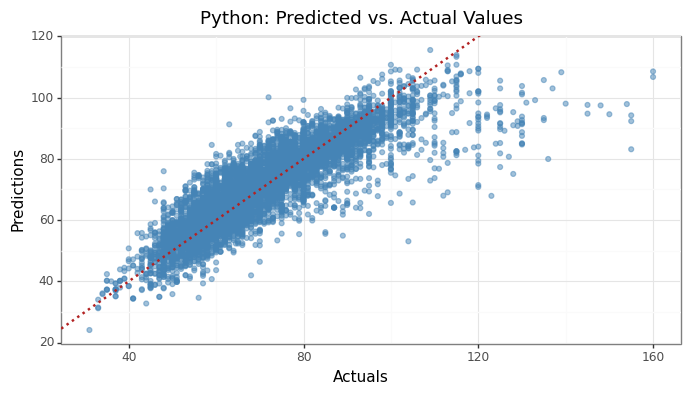

<ggplot: (89547214173)>

In [211]:
predictions = pd.DataFrame(
    {"predictions": search.predict(X_test), "truth": y_test})

p = (ggplot(data=predictions, mapping=aes(x="truth", y="predictions")) +
    geom_point(colour="#4584b6", alpha=0.5) +
    geom_abline(colour="firebrick", linetype="dotted", size=1) +
    labs(title="Python: Predicted vs. Actual Values",
         y="Predictions", x="Actuals") +
    theme_bw() +
    theme(figure_size=[8, 4])
)

p

In [212]:
(p + theme(figure_size=[4,4])).save(dpi=350, filename="python.png")

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: python.png
